# Slack Summaries
This notebook shows how to ingest Slack messages and generate threads summaries.

NOTE. This notebook uses data generated on a dummy Slack server, so messages, replies, and summaries aren't really insightful.

## Pre-requisites
The first step is to `dlt init` the Slack pipeline, but this is already done for this repository. All you need to do is configure your Slack application to get a User OAuth Token (see [docs](https://dlthub.com/docs/dlt-ecosystem/verified-sources/slack)). Then, you can it add it to `.dlt/secrets.toml` as follow:

```toml
[sources.slack]
access_token = "xoxb-..."
```

## Extract & Load (dlt)
The "extract" and "load" steps consist of getting the raw data to destination for further transformations.

### Set up
Define your dlt `Pipeline` and `Source`

In [1]:
import dlt
import slack

slack_pipeline = dlt.pipeline(
    pipeline_name="slack",
    destination='duckdb',
    dataset_name="slack_data",
    full_refresh=True,
)

dlt_source = slack.slack_source(
    selected_channels=["general", "dlt"],
    replies=True,
)

print(f"""{slack_pipeline.dataset_name=:}
{slack_pipeline.pipeline_name=:}""")

slack_pipeline.dataset_name=slack_data_20240404085714
slack_pipeline.pipeline_name=slack


### Execution
Run your dlt pipeline. `load_info` will contain a lot metadata about execution.

In [2]:
load_info = slack_pipeline.run(dlt_source)
print(load_info)

Pipeline slack load step completed in 1.05 seconds
1 load package(s) were loaded to destination duckdb and into dataset slack_data_20240404085714
The duckdb destination used duckdb:////home/tjean/projects/dagworks/hamilton/examples/dlt/slack.duckdb location to store data
Load package 1712264235.2934568 is LOADED and contains no failed jobs


## Transform (Hamilton + Ibis)

Now that raw data is loaded (in DuckDB), we use Hamilton to organize a dataflow of Ibis data transformations.  

## Define

In the next cells, we use Python functions to define a Hamilton dataflow. 

By using the Hamilton Jupyter plugin, we can define the dataflow interactively. Adding and removing functions to the cell will change its shape. 

In [3]:
%load_ext hamilton.plugins.jupyter_magic
from IPython.display import display

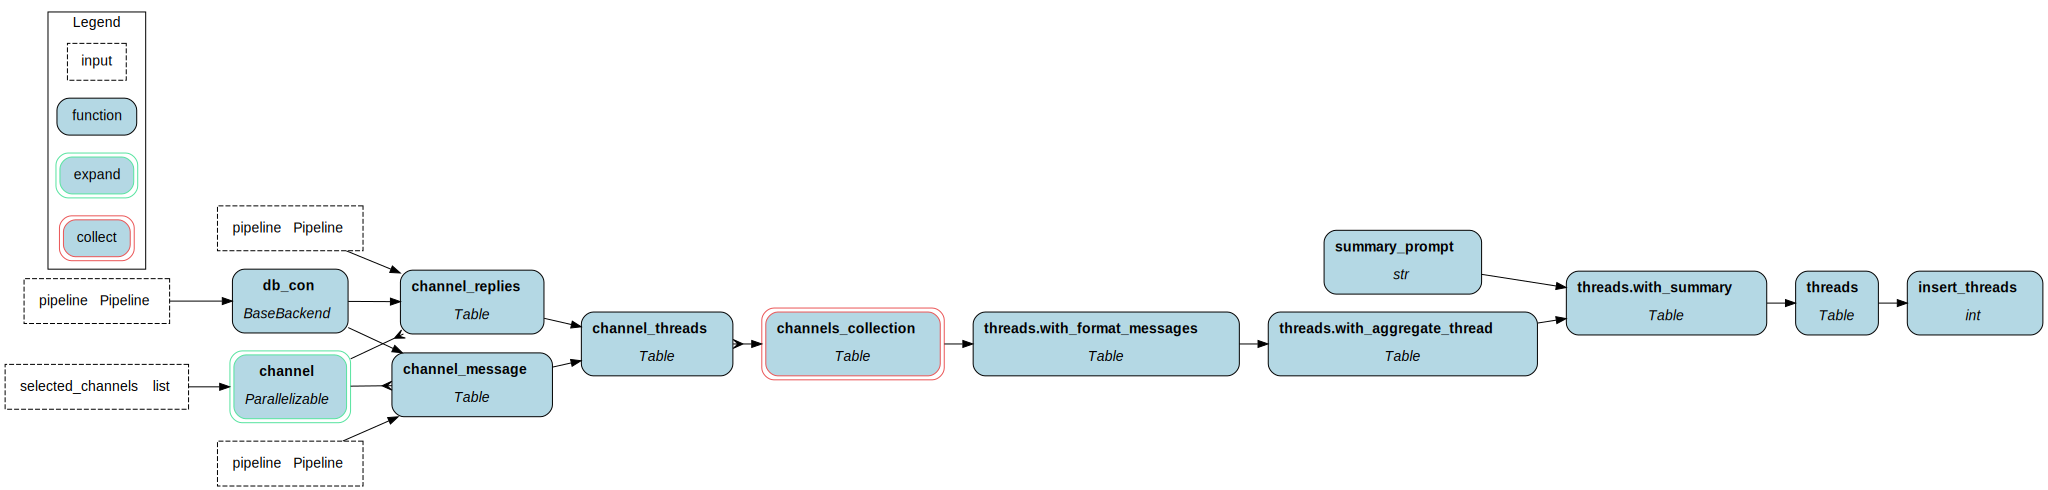

In [4]:
%%cell_to_module -m jupyter_transform -d

import textwrap

import dlt
import ibis
import ibis.expr.types as ir
import openai
from hamilton.function_modifiers import pipe, source, step
from hamilton.htypes import Parallelizable, Collect


def db_con(pipeline: dlt.Pipeline) -> ibis.BaseBackend:
    backend = ibis.connect(f"{pipeline.pipeline_name}.duckdb")
    ibis.set_backend(backend)
    return backend


def channel(selected_channels: list[str]) -> Parallelizable[str]:
    for channel in selected_channels:
        yield channel


def _epoch_microseconds(timestamp: ir.Column) -> ir.Column:
    seconds_from_epoch = timestamp.epoch_seconds()
    microseconds = timestamp.microsecond() / int(10e5)
    return seconds_from_epoch + microseconds
    

def channel_message(
    channel: str,
    db_con: ibis.BaseBackend, 
    pipeline: dlt.Pipeline,
) -> ir.Table:
    """Load table containing parent messages of a channel.
    the timestamps `thread_ts` and `ts` are converted to strings.
    `thread_ts` is not None if the message has replies / started a thread. Otherwise,
    `thread_ts` == `ts`. Coalesce is used to fill these None values with `ts`

    Slack reference: https://api.slack.com/messaging/retrieving#finding_threads
    """
    return (
        db_con.table(
            f"{channel}_message",
            schema=pipeline.dataset_name,
            database=pipeline.pipeline_name,
        )
        .mutate(
            thread_ts=_epoch_microseconds(ibis._.thread_ts).cast(str),
            ts=_epoch_microseconds(ibis._.ts).cast(str),
        )
        .mutate(thread_ts=ibis.coalesce(ibis._.thread_ts, ibis._.ts))
    )


def channel_replies(
    channel: str,
    db_con: ibis.BaseBackend, 
    pipeline: dlt.Pipeline,
) -> ir.Table:
    """Create table for replies"""
    return db_con.table(
        f"{channel}_replies_message",
        schema=pipeline.dataset_name,
        database=pipeline.pipeline_name,
    )
    

def channel_threads(channel_message: ir.Table, channel_replies: ir.Table) -> ir.Table:
    """Union of parent messages and replies. Sort by thread start, then message timestamp"""
    columns = ["channel", "thread_ts", "ts", "user", "text", "_dlt_load_id", "_dlt_id"]
    return (
        ibis.union(
            channel_message.select(columns),
            channel_replies.select(columns),
        )
        .order_by([ibis._.thread_ts, ibis._.ts])
    )


def channels_collection(channel_threads: Collect[ir.Table]) -> ir.Table:
    """Collect `channel_threads` for all channels"""
    return ibis.union(*channel_threads)


def _format_messages(threads: ir.Table) -> ir.Table:
    """Assign a user id per thread and prefix messages with it"""
    thread_user_id_expr = (ibis.dense_rank().over(order_by="user") + 1).cast(str)
    return threads.group_by("thread_ts").mutate(
        message=thread_user_id_expr.concat(": ", ibis._.text)
    )


def _aggregate_thread(threads: ir.Table) -> ir.Table:
    """Create threads as a single string by concatenating messages

    Functions decorates with `@ibis.udf` are loaded by the Ibis backend.
    They aren't meant to be called directly.
    ref: https://ibis-project.org/how-to/extending/builtin
    """

    @ibis.udf.agg.builtin(name="string_agg")
    def _string_agg(arg, sep: str = "\n ") -> str:
        raise NotImplementedError

    @ibis.udf.agg.builtin(name="array_agg")
    def _array_agg(arg) -> list[str]:
        raise NotImplementedError

    return threads.group_by("thread_ts").agg(
        thread=_string_agg(ibis._.message),
        num_messages=ibis._.count(),
        users=_array_agg(ibis._.user).unique(),
        _dlt_load_id=ibis._._dlt_load_id.max(),
        _dlt_id=_array_agg(ibis._._dlt_id),
    )


def summary_prompt() -> str:
    """LLM prompt to summarize Slack thread"""
    return textwrap.dedent(
        """Hamilton is an open source library to write dataflows in Python. It is used by developers for data engineering, data science, machine learning, and LLM workflows.
        Next is a discussion thread about Hamilton started by User1. Complete these tasks: identify the issue raised by User1, summarize the discussion, indicate if you think the issue was resolved.

        DISCUSSION THREAD
        {text}
        """
    )

def _summary(threads: ir.Table, prompt: str) -> ir.Table:
    """Generate a summary for each thread.
    Uses a scalar Python UDF executed by the backend.
    """
    # Ibis requires `str` type hint even if None is allowed
    @ibis.udf.scalar.python
    def _openai_completion_udf(text: str, prompt_template: str) -> str:
        """Fill `prompt` with `text` and use OpenAI chat completion.
        Returns None if:
            - `text` is empty
            - `content` is too long
            - OpenAI call fails
        """
        if len(text) == 0:
            return None

        content = prompt_template.format(text=text)

        if len(content) // 4 > 8191:
            return None

        client = openai.OpenAI()

        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": content}],
        )
        try:
            output = response.choices[0].message.content
        except Exception:
            output = None

        return output
    
    return threads.mutate(summary=_openai_completion_udf(threads.thread, prompt))


# @pipe operator facilitates managing the function/node namespace
@pipe(
    step(_format_messages), step(_aggregate_thread), step(_summary, prompt=source("summary_prompt"))
)
def threads(channels_collection: ir.Table) -> ir.Table:
    """Create `threads` table by formatting, aggregating messages,
    and generating summaries.
    """
    return channels_collection


def insert_threads(threads: ir.Table) -> int:
    """Save `threads` table and return row count."""
    db_con = ibis.get_backend()
    threads_table = db_con.create_table("threads", threads)
    db_con.insert("threads", threads)
    return int(threads_table.count().execute())

## Execute
Create a Hamilton Driver with the defined dataflow module and request nodes to compute. 

### Driver definition

We pass the module `jupyter_transform` that we defined in this notebook, but it could be modules stored in `.py` files. The `.enable_dynamic_execution()` statement is required because we're using Hamilton's `Parallelizable/Collect` feature.

In [5]:
from hamilton import driver
import jupyter_transform

dr = (
    driver.Builder()
    .enable_dynamic_execution(allow_experimental_mode=True)
    .with_modules(jupyter_transform)
    .build()
)

### Driver execution
We create a dictionary to hold the inputs `pipeline` and `selected_channels` (the same passed to the dlt pipeline) required by the Hamilton dataflow.

Then, we call `dr.execute()` with the list of nodes to compute and the inputs. This returns a dictionary of results.

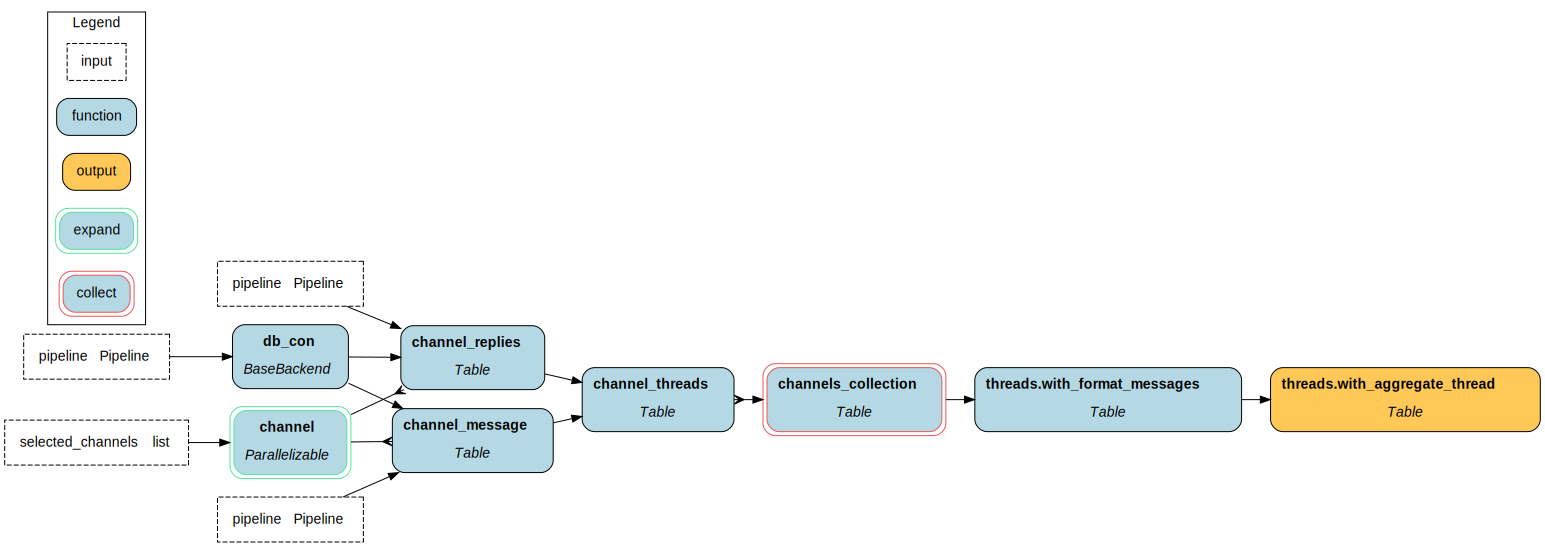

,thread_ts,thread,num_messages,users,_dlt_load_id,_dlt_id
0,1711048769.908319,1: from the general channel again,1,[U06R4CY0Q65],1712264235.2934568,[YzwD7S5kc4OYeA]
1,1711053147.089719,1: along with a reply\n 1: another message,2,[U06R4CY0Q65],1712264235.2934568,"[LItHtsbAAX6/Kg, XFxI2RmALQkXfg]"
2,1711048757.443209,1: hello world,1,[U06R4CY0Q65],1712264235.2934568,[x/vVKj7+sMyNvg]
3,1711048765.747779,1: general channel,1,[U06R4CY0Q65],1712264235.2934568,[aT+AcnCycBlp8A]
4,1711048761.709929,1: 2nd message,1,[U06R4CY0Q65],1712264235.2934568,[ENPKHYpQW15AFg]
5,1711048764.747779,1: my 2nd reply\n 1: will this be picked up by...,3,[U06R4CY0Q65],1712264235.2934568,"[kEt1kEo9e0mkqQ, LatviGHcnPd8yw, lyx94g8HxvVcIA]"


In [6]:
inputs = dict(
    pipeline=slack_pipeline,
    selected_channels=["general", "dlt"],
)  
final_vars = ["threads.with_aggregate_thread"]

results = dr.execute(final_vars, inputs=inputs)
# `threads.with_aggregate_thread` is an ibis expr, execute it to return a pandas DataFrame
df = results["threads.with_aggregate_thread"].to_pandas()

display(dr.visualize_execution(final_vars=final_vars, inputs=inputs), df)

The next cells require your OpenAI key to execute the full dataflow and compute the summaries. By requesting `insert_threads`, we could directly save the Ibis results without leaving DuckDB!

In [7]:
import os 
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI key")

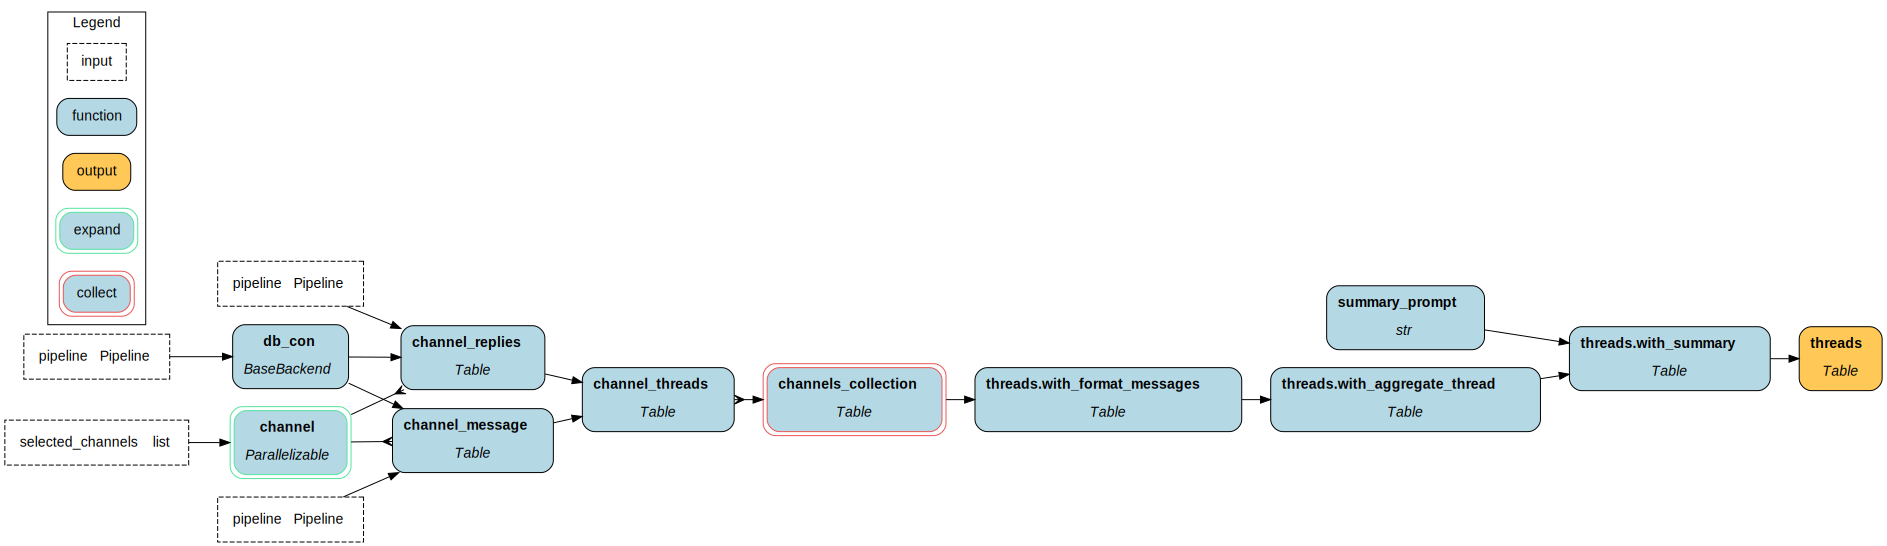

,thread_ts,thread,num_messages,users,_dlt_load_id,_dlt_id,summary
0,1711048769.908319,1: from the general channel again,1,[U06R4CY0Q65],1712264235.2934568,[YzwD7S5kc4OYeA],User1: Has anyone encountered issues with Hami...
1,1711053147.089719,1: another message\n 1: along with a reply,2,[U06R4CY0Q65],1712264235.2934568,"[XFxI2RmALQkXfg, LItHtsbAAX6/Kg]","User1:\n Hey everyone, I'm having troub..."
2,1711048757.443209,1: hello world,1,[U06R4CY0Q65],1712264235.2934568,[x/vVKj7+sMyNvg],"2: Hi User1, what's up?\n \n 3: ..."
3,1711048761.709929,1: 2nd message,1,[U06R4CY0Q65],1712264235.2934568,[ENPKHYpQW15AFg],"User1: Hi everyone, I've been using Hamilton f..."
4,1711048765.747779,1: general channel,1,[U06R4CY0Q65],1712264235.2934568,[aT+AcnCycBlp8A],"User1: ""I've been trying to use Hamilton for m..."
5,1711048764.747779,1: my 2nd reply\n 1: my 1st reply\n 1: will th...,3,[U06R4CY0Q65],1712264235.2934568,"[kEt1kEo9e0mkqQ, lyx94g8HxvVcIA, LatviGHcnPd8yw]",User1's issue: User1 is questioning whether ce...


In [8]:
final_vars = ["threads"]   # replace by `"insert_threads"` to directly store results
results = dr.execute(final_vars, inputs=inputs)
df2 = results["threads"].to_pandas()

display(dr.visualize_execution(final_vars=final_vars, inputs=inputs), df2)